# DEEP LEARNING EXAM
### Image Segmentation project




### Requirements

In [1]:
!pip install imgaug > /dev/null 2>&1
!pip install pydot > /dev/null 2>&1
!pip install pydotplus > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install graphviz > /dev/null 2>&1
!pip install theano > /dev/null 2>&1
!pip install visualkeras > /dev/null 2>&1
!pip install keras-tuner  > /dev/null 2>&1

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle as pk

import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

import imgaug.augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from keras.utils import to_categorical, plot_model
import keras_tuner as kt


# **Load Dataset file from GitHub Repository**


---



In [3]:
import urllib.request
import zipfile
# ZIP data URL from GitHub
zip_url = "https://github.com/pietrosaveri/DL_exam/raw/main/input_data.zip"
# Download the ZIP
zip_path, _ = urllib.request.urlretrieve(zip_url)
# Unzip the folder
target_folder = "temp"
# reading data
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)
data_path = f"{target_folder}/input_data.pkl"

In [4]:
import pickle as pk
with open(data_path, 'rb') as f:
    dd = pk.load(f)

imgs = dd['imgs']
masks = dd['masks']



---


### ***Visualize images***

In [5]:
print("image shapes", imgs.shape)
print("masks shape", masks.shape)

image shapes (1305, 256, 256, 3)
masks shape (1305, 256, 256, 1)


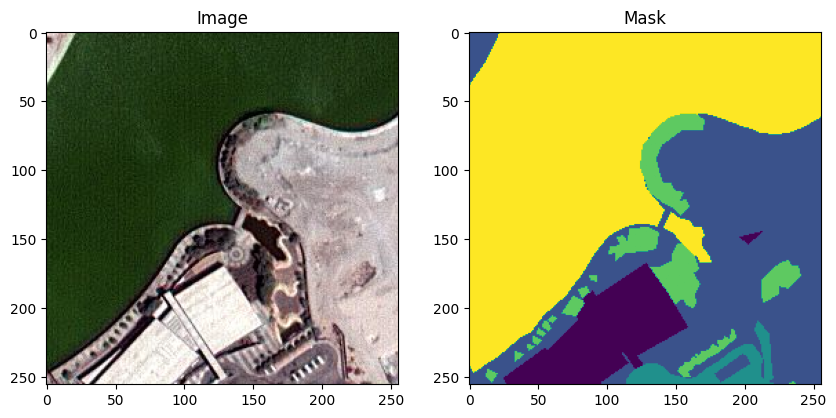

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(imgs[42])
axes[0].set_title('Image')

axes[1].imshow(masks[42])
axes[1].set_title('Mask')

plt.show()

# **Exam Question 2**

---



## Resize images to (128, 128) (**2A**)

In [7]:
new_size = (128, 128)

In [8]:
resized_imgs = np.zeros((imgs.shape[0], new_size[0], new_size[1], imgs.shape[3]), dtype=imgs.dtype)
resized_masks = np.zeros((masks.shape[0], new_size[0], new_size[1], masks.shape[3]), dtype=masks.dtype)

for i in range(imgs.shape[0]):
    resized_imgs[i] = cv2.resize(imgs[i], new_size)
    resized_mask = cv2.resize(masks[i], new_size)
    resized_masks[i] = np.expand_dims(resized_mask, axis=-1)

imgs = resized_imgs
masks = resized_masks

In [9]:
print("image shapes", imgs.shape)
print("masks shape", masks.shape)

image shapes (1305, 128, 128, 3)
masks shape (1305, 128, 128, 1)


### *Plot the reseized image*

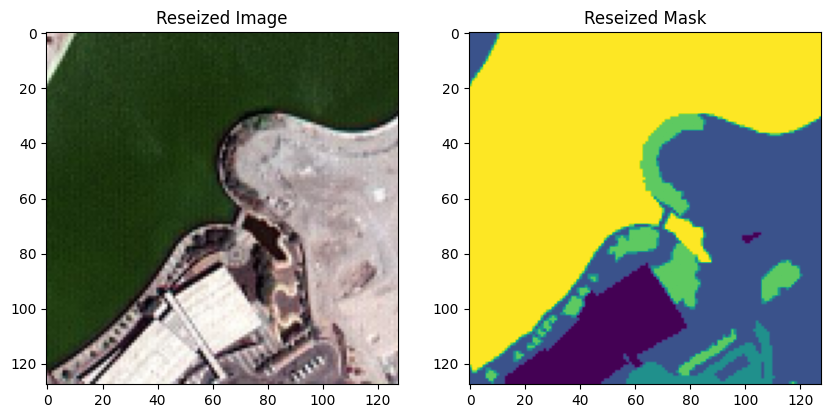

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(imgs[42])
axes[0].set_title('Reseized Image')

axes[1].imshow(masks[42])
axes[1].set_title('Reseized Mask')

plt.show()

# Data Augmentation (**2A**)

Using the imgaug library, we can augment our dataset by applying various transformations such as rotating (90˚, 180˚, 270˚), flipping (horizontally, vertically), and scaling (by 20%).

In [13]:
rotate_90 = iaa.Affine(rotate=90)
rotate_180 = iaa.Affine(rotate=180)
rotate_270 = iaa.Affine(rotate=270)
flip_h = iaa.Fliplr(1.0) #Horizontal flip
flip_v = iaa.Flipud(1.0) #Vertical flip
zoom_in = iaa.Affine(scale=1.2) #Zoom by 20%

In [14]:
augmented_imgs = []
augmented_masks = []

for i in range(imgs.shape[0]):
    # Original image and mask
    augmented_imgs.append(imgs[i])
    augmented_masks.append(masks[i])

    # Rotated images and masks
    augmented_imgs.append(rotate_90(image=imgs[i]))
    augmented_masks.append(rotate_90(image=masks[i]))

    augmented_imgs.append(rotate_180(image=imgs[i]))
    augmented_masks.append(rotate_180(image=masks[i]))

    augmented_imgs.append(rotate_270(image=imgs[i]))
    augmented_masks.append(rotate_270(image=masks[i]))

    # Flipped images and masks
    augmented_imgs.append(flip_h(image=imgs[i]))
    augmented_masks.append(flip_h(image=masks[i]))

    augmented_imgs.append(flip_v(image=imgs[i]))
    augmented_masks.append(flip_v(image=masks[i]))

    # Zoomed images and masks
    augmented_imgs.append(zoom_in(image=imgs[i]))
    augmented_masks.append(zoom_in(image=masks[i]))

augmented_imgs = np.array(augmented_imgs)
augmented_masks = np.array(augmented_masks)


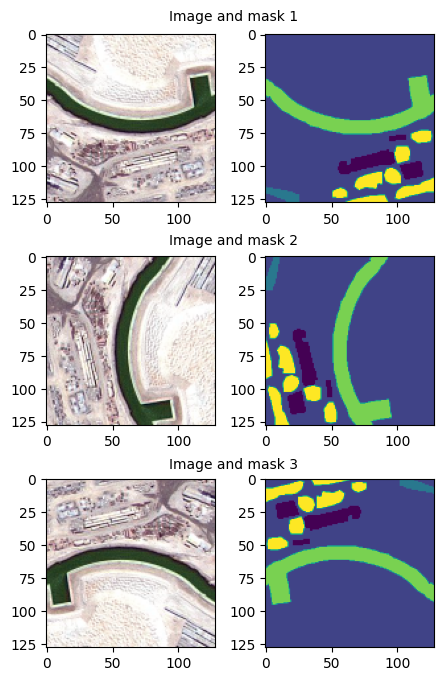

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(5, 8))
axes[0, 0].imshow(augmented_imgs[1])
axes[0, 1].imshow(augmented_masks[1])

axes[1, 0].imshow(augmented_imgs[2])
axes[1, 1].imshow(augmented_masks[2])

axes[2, 0].imshow(augmented_imgs[3])
axes[2, 1].imshow(augmented_masks[3])

fig.text(0.5, 0.90, 'Image and mask 1', ha='center', va='center', fontsize=10)
fig.text(0.5, 0.62, 'Image and mask 2', ha='center', va='center', fontsize=10)
fig.text(0.5, 0.34, 'Image and mask 3', ha='center', va='center', fontsize=10)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

### Shuffle the dataset to avoid learning based on the order

In [16]:
imgs, masks = shuffle(augmented_imgs, augmented_masks, random_state=42)

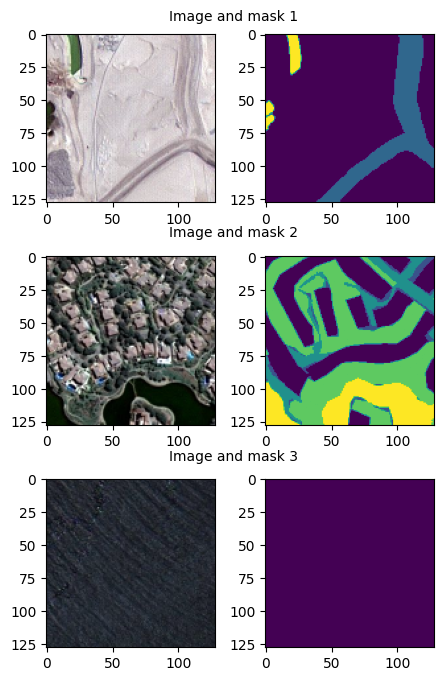

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(5, 8))
axes[0, 0].imshow(imgs[1])
axes[0, 1].imshow(masks[1])

axes[1, 0].imshow(imgs[2])
axes[1, 1].imshow(masks[2])

axes[2, 0].imshow(imgs[3])
axes[2, 1].imshow(masks[3])

fig.text(0.5, 0.90, 'Image and mask 1', ha='center', va='center', fontsize=10)
fig.text(0.5, 0.63, 'Image and mask 2', ha='center', va='center', fontsize=10)
fig.text(0.5, 0.35, 'Image and mask 3', ha='center', va='center', fontsize=10)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

# One hot encode the Masks (**2A**)

In [18]:
def one_hot_encode_masks(masks, num_classes):
    # Convert masks to categorical (one-hot encoding)
    masks_one_hot = []
    for mask in masks:
        mask = mask.squeeze()  # Remove single-dimensional entries from the shape of an array
        mask_one_hot = to_categorical(mask, num_classes=num_classes)
        masks_one_hot.append(mask_one_hot)
    return np.array(masks_one_hot)

In [19]:
num_classes = 6  # Example number of classes
masks_one_hot = one_hot_encode_masks(masks, num_classes)

In [20]:
masks_one_hot.shape

(9135, 128, 128, 6)

# Set images into [0, 1] Range (**2A**)

In [21]:
imgs = imgs/255

# Train Test Split (**2A**)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(imgs, masks_one_hot, test_size=0.2, random_state=42)

# INPUT SHAPE (**2B**)

In [23]:
print("images size", X_train.shape)
print("Masks size", y_train.shape)

images size (7308, 128, 128, 3)
Masks size (7308, 128, 128, 6)


# **Exam Question 3**


---
We are going to use the output layer in point 5
But it is goint to be defined as:



```
# outputs = Conv2D(num_classes, 3, padding='same', activation='softmax', )(c3)
```




# **Exam Question 4**


---
As loss function we are going to use `categorical crossentropy` in point 5



```
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy", metrics=['accuracy'])
```





# **Exam Question 5**


---
We are first going to try a very basic` U-Net` Architecture to check if it working correctly. After this, we will use the Hyperparametrization tuning to find the best model




###Activation Function (**5B**)

As activation function for the hidden layers of our model we will use the `relu` activation function.

For exameple:


```
# c1 = Conv2D(filters[0], (3, 3), activation='relu', padding='same') (inputs)

```

---

As activation function for the output layer of our model we will use the `softmax` activation function.

For example:



```
# outputs = Conv2D(num_classes, 3, padding='same', activation='softmax', )(c3)
```







# Basic U-Net Architecture

As a first step, we want to make sure that our model works as intended and we do so by creating a baseline model.

In [24]:
filters = [8, 16]

# Input layer
inputs = Input(shape=(128, 128, 3))

# Encoder
c1 = Conv2D(filters[0], (3, 3), activation='relu', padding='same') (inputs)
p1 = MaxPooling2D((2, 2)) (c1)

# Bottleneck
c2 = Conv2D(filters[1], (3, 3), activation='relu', padding='same') (p1)

# Decoder
u3 = UpSampling2D((2, 2)) (c2)
u3 = concatenate([u3, c1])
c3 = Conv2D(filters[0], (3, 3), activation='relu', padding='same') (u3)

outputs = Conv2D(num_classes, 3, padding='same', activation='softmax', )(c3)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss="categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 8)          224       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 8)            0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 16)           1168      ['max_pooling2d[0][0]']   

### Basic U-Net Architecture Training

In [25]:
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    batch_size=32,
    epochs=2
)

Epoch 1/2
206/206 [==============================] - 43s 202ms/step - loss: 0.9763 - accuracy: 0.6408 - val_loss: 0.7565 - val_accuracy: 0.7266
Epoch 2/2
206/206 [==============================] - 41s 197ms/step - loss: 0.7245 - accuracy: 0.7414 - val_loss: 0.6965 - val_accuracy: 0.7476


###  Basic U-Net Architecture Evaluation

In [26]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

58/58 [==============================] - 2s 40ms/step - loss: 0.7027 - accuracy: 0.7419
Test loss: 0.7026772499084473
Test accuracy: 0.7419297099113464


### Is the model overfitted?

In [27]:
train_accuracy = history.history.get('accuracy', None)
val_accuracy = history.history.get('val_accuracy', None)

if train_accuracy and val_accuracy:
    print(f'Final Training Accuracy: {train_accuracy[-1]}')
    print(f'Final Validation Accuracy: {val_accuracy[-1]}')
else:
    print("Accuracy metrics not found in history.")

Final Training Accuracy: 0.7413884997367859
Final Validation Accuracy: 0.74758380651474


# **Discover the Optimal Model with Hyperparameter Tuning and Cross-Validation** (**5C/6**)


---
> After experimenting with a larger and more complex U-Net architecture, I noticed it was slightly prone to overfitting. To address this, I will incorporate dropout layers and L2 regularization in the following model.
>> Note: For the L2 weight coefficient and dropout rate, I will set the minimum value to 0. This allows the model to choose not to apply these regularization techniques if it determines that doing so is not beneficial.

With this in mind, I will perform hyperparameter tuning on these parameters.


*   Learning rate
*   Batch_size
*   Dropout Rate
*   Number of filters in Convolutional Layers
*   Weight regularization



In [28]:
def unet_model(input_shape=(128, 128, 3), filters=[8, 12, 16, 20, 24], dropout_rate=0.5, l2_reg=0.01):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (inputs)
    c1 = Dropout(dropout_rate) (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (p1)
    c2 = Dropout(dropout_rate) (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (p2)
    c3 = Dropout(dropout_rate) (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(filters[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (p3)
    c4 = Dropout(dropout_rate) (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    # Bottleneck
    c5 = Conv2D(filters[4], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (p4)
    c5 = Dropout(dropout_rate) (c5)

    # Decoder
    u6 = UpSampling2D((2, 2)) (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(filters[3], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (u6)
    c6 = Dropout(dropout_rate) (c6)

    u7 = UpSampling2D((2, 2)) (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(filters[2], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (u7)
    c7 = Dropout(dropout_rate) (c7)

    u8 = UpSampling2D((2, 2)) (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(filters[1], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (u8)
    c8 = Dropout(dropout_rate) (c8)

    u9 = UpSampling2D((2, 2)) (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(filters[0], (3, 3), activation='relu', kernel_initializer='he_normal', padding='same',
                kernel_regularizer=l2(l2_reg)) (u9)
    c9 = Dropout(dropout_rate) (c9)

    #Output
    outputs = Conv2D(num_classes, 3, padding='same', activation='softmax') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [29]:
def build_model(hp):
    input_shape = (128, 128, 3)
    filters = hp.Choice('filters', values=[8, 12, 16, 20, 24])
    dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.3, step=0.1)
    l2_reg = hp.Float('l2_reg', min_value=0.000, max_value=0.01, step=0.001)
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    batch_size = hp.Int('batch_size', min_value=8, max_value=32, step=8)

    model = unet_model(input_shape=input_shape, filters=[filters]*5, dropout_rate=dropout_rate, l2_reg=l2_reg)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='unet_tuning',
    project_name='image_segmentation'
)

Reloading Tuner from unet_tuning/image_segmentation/tuner0.json


> By using nested cross-validation, we can simultaneously perform cross-validation and hyperparameter tuning. This approach allows us to optimize the model and its hyperparameters effectively. The results include 2 outputs:

1. `best_model`: The model with the highest performance found through the nested cross-validation.
2. `best_hps`: The hyperparameters associated with the best_model.



In [30]:
def nested_cross_validate(X, y, outer_splits=2, inner_splits=2, epochs=5):
    outer_kf = KFold(n_splits=outer_splits, shuffle=True, random_state=42)
    outer_scores = []
    best_model = None
    best_hps = None

    for outer_fold, (train_val_index, test_index) in enumerate(outer_kf.split(X), start=1):
        print(f'\nOuter Fold {outer_fold}/{outer_splits}')

        X_train_val, X_test = X[train_val_index], X[test_index]
        y_train_val, y_test = y[train_val_index], y[test_index]

        inner_kf = KFold(n_splits=inner_splits, shuffle=True, random_state=42)
        best_val_score = -np.inf
        best_hps_fold = None

        for inner_fold, (train_index, val_index) in enumerate(inner_kf.split(X_train_val), start=1):
            print(f'Inner Fold {inner_fold}/{inner_splits}')

            X_train, X_val = X_train_val[train_index], X_train_val[val_index]
            y_train, y_val = y_train_val[train_index], y_train_val[val_index]

            # Search for the best hyperparameters
            print('Searching for best hyperparameters...')
            tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs)
            hp_best = tuner.get_best_hyperparameters(num_trials=1)[0]

            print(f'Best Hyperparameters: {hp_best.values}')
            model = tuner.hypermodel.build(hp_best)
            batch_size = hp_best.get('batch_size')

            # Train the model with the best batch size
            print('Training model...')
            history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

            val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
            val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]

            print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')

            if val_accuracy > best_val_score:
                best_val_score = val_accuracy
                best_hps_fold = hp_best

        print(f'Best Hyperparameters for Fold {outer_fold}: {best_hps_fold.values}')

        # Retrain the best model for the current outer fold
        print('Retraining best model')
        best_model_for_fold = tuner.hypermodel.build(best_hps_fold)
        batch_size = best_hps_fold.get('batch_size')
        best_model_for_fold.fit(X_train_val, y_train_val, epochs=epochs, batch_size=batch_size, verbose=0)

        test_loss = best_model_for_fold.evaluate(X_test, y_test, verbose=0)[0]
        outer_scores.append(test_loss)
        print(f'Fold test loss: {test_loss}')

        if best_model is None or test_loss < np.mean(outer_scores):
            best_model = best_model_for_fold
            best_hps = best_hps_fold

    print(f'Nested cross-validated loss: {np.mean(outer_scores)} ± {np.std(outer_scores)}')
    print(f'Best Hyperparameters: {best_hps.values}')

    return best_model, best_hps


In [31]:
best_model, best_hps = nested_cross_validate(X_train, y_train, outer_splits=2, inner_splits=2, epochs=5)


Outer Fold 1/2
Inner Fold 1/2
Searching for best hyperparameters...
Best Hyperparameters: {'filters': 24, 'dropout_rate': 0.0, 'l2_reg': 0.007, 'learning_rate': 0.0009120605909040556, 'batch_size': 8}
Training model...
Epoch 1/5
229/229 [==============================] - 47s 198ms/step - loss: 2.2925 - accuracy: 0.6622 - val_loss: 1.4927 - val_accuracy: 0.7249
Epoch 2/5
229/229 [==============================] - 43s 188ms/step - loss: 1.3229 - accuracy: 0.7388 - val_loss: 1.1821 - val_accuracy: 0.7503
Epoch 3/5
229/229 [==============================] - 44s 194ms/step - loss: 1.1034 - accuracy: 0.7526 - val_loss: 1.0411 - val_accuracy: 0.7612
Epoch 4/5
229/229 [==============================] - 43s 188ms/step - loss: 0.9994 - accuracy: 0.7606 - val_loss: 0.9522 - val_accuracy: 0.7669
Epoch 5/5
229/229 [==============================] - 43s 189ms/step - loss: 0.9276 - accuracy: 0.7692 - val_loss: 0.9038 - val_accuracy: 0.7733
Validation Loss: 0.903806746006012, Validation Accuracy: 0.7

### Print the performed hyperparameters trials

In [32]:
for trial in tuner.oracle.get_best_trials(num_trials=5):
    print(trial.hyperparameters.values)

{'filters': 24, 'dropout_rate': 0.0, 'l2_reg': 0.007, 'learning_rate': 0.0009120605909040556, 'batch_size': 8}
{'filters': 16, 'dropout_rate': 0.0, 'l2_reg': 0.003, 'learning_rate': 0.0007587134869670999, 'batch_size': 8}
{'filters': 8, 'dropout_rate': 0.2, 'l2_reg': 0.004, 'learning_rate': 0.0013230002827791072, 'batch_size': 32}
{'filters': 20, 'dropout_rate': 0.1, 'l2_reg': 0.002, 'learning_rate': 8.661833038196316e-05, 'batch_size': 16}
{'filters': 20, 'dropout_rate': 0.1, 'l2_reg': 0.002, 'learning_rate': 1.3808789760251268e-05, 'batch_size': 8}


### Best model Representation

In [33]:
print("Best model summary:")
best_model.summary()

Best model summary:
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_54 (Conv2D)          (None, 128, 128, 24)         672       ['input_7[0][0]']             
                                                                                                  
 dropout_45 (Dropout)        (None, 128, 128, 24)         0         ['conv2d_54[0][0]']           
                                                                                                  
 max_pooling2d_21 (MaxPooli  (None, 64, 64, 24)           0         ['dropout_45[0][0]']          
 ng2D)                                                                  

By using `visualkeras` we can see a very nice representation of the best_model.

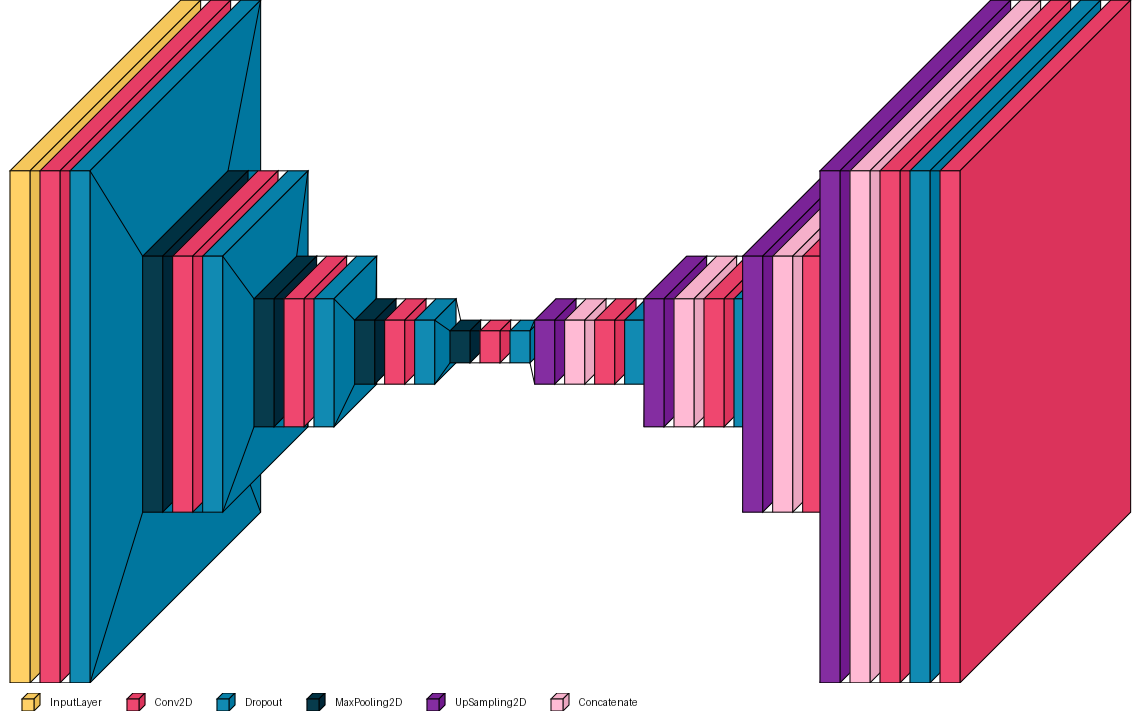

In [34]:
import visualkeras
visualkeras.layered_view(best_model, legend=True)

### **Show the hyperparameters of the best model**

---
Thanks to the second output from our nested cross-validation, we can identify the hyperparameters of the best model.


In [35]:
# Print the best hyperparameters
print('Best Hyperparameters:')
for key, value in best_hps.values.items():
    print(f'{key}: {value}')

Best Hyperparameters:
filters: 24
dropout_rate: 0.0
l2_reg: 0.007
learning_rate: 0.0009120605909040556
batch_size: 8


### **Best model final accuracy**

In [36]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

58/58 [==============================] - 5s 82ms/step - loss: 0.7635 - accuracy: 0.7834
Test loss: 0.7634825110435486
Test accuracy: 0.783410906791687


# **Fit** the best **model** to our entire dataset to retrive the history

---
Now that we have identified the best model through hyperparameter tuning, we can fit it to our entire dataset to print some interesting results.



In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

#recall best batch size from the hyperparameters
best_batch_size = best_hps.get('batch_size')

history = best_model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    epochs=50,
    batch_size=best_batch_size,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the final model on the test set
final_loss, final_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f'Final test accuracy: {final_accuracy}')

Epoch 1/50
823/823 [==============================] - 136s 166ms/step - loss: 0.7454 - accuracy: 0.7895 - val_loss: 0.7215 - val_accuracy: 0.7896
Epoch 2/50
823/823 [==============================] - 136s 165ms/step - loss: 0.7114 - accuracy: 0.7924 - val_loss: 0.6923 - val_accuracy: 0.7977
Epoch 3/50
205/823 [======>.......................] - ETA: 1:39 - loss: 0.6978 - accuracy: 0.7932

# **BEST MODEL FINAL EVALUATION** (**6**)


---

I tried to add a validation curve to show how different learning rates impact the loss during our nested cross-validation.

The idea was to store all the learning rate trials and thier respective losses and plot these metrics to better understand their relationship. Despite many attempts and a lot of effort, I wasn’t able to get this curve working as planned.

### **Learnign Curve** (epochs-Loss / epochs-accuracy)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot training & validation loss values
ax[0].plot(history.history['loss'], label='Training Loss')
ax[0].plot(history.history['val_loss'], label='Validation Loss')
ax[0].set_title('Model Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper left')
ax[0].grid(True)

# Plot training & validation accuracy values (if applicable)
if 'accuracy' in history.history:
    ax[1].plot(history.history['accuracy'], label='Training Accuracy')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[1].set_title('Model Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='upper left')
    ax[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


### **Visualization of true Maks and Predicted Masks**

---
Something very interesting that we can do now is to show the actual masks of the images and the masks predicted by our model.



In [ ]:
predictions = best_model.predict(X_test)

predicted_labels = np.argmax(predictions, axis=-1)

def display_sample(x, y, pred, index):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Image')
    plt.imshow(x[index])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('True Mask')
    plt.imshow(np.argmax(y[index], axis=-1))
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(pred[index])
    plt.axis('off')

    plt.show()

# Display a few examples
for i in range(7, 15, 1):
    display_sample(X_test, y_test, predicted_labels, i)


# **Conclusion**


---
This project demonstrated the successful development of a deep learning model for image segmentation, achieving an accuracy of around 0.8. The model effectively predicts segmented masks, with results confirmed through visual inspection.

We utilized cross-validation and hyperparameter tuning to optimize performance, ensuring reliable and generalizable results.

Overall, the model’s performance highlights its suitability for practical applications in image segmentation.
